# <center>  AI / ML Project - Heart Disease Diagnosis 
#### <center> ***Domain: Healthcare***

### Description:

This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. In particular, the Cleveland database is the only one that has been used by ML researchers to
this date. The "goal" field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4.

---

# <center>1. Data Exploration

In [1]:
#Importing the basic librarires

import os
import math
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from scipy.stats import randint
from scipy.stats import loguniform
from IPython.display import display

from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from scikitplot.metrics import plot_roc_curve as auc_roc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, \
f1_score, roc_auc_score, roc_curve, precision_score, recall_score

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)

In [2]:
#Importing the dataset

df = pd.read_csv('../input/heart-disease-dataset/heart.csv')
#df.drop([''],axis=1, inplace=True)

target = 'target'
labels = ['Healthy Patients','Heart-Disease Patients']
features = [i for i in df.columns.values if i not in [target]]

original_df = df.copy(deep=True)
display(df.head())

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1


Inference: The Datset consists of 14 features & 303 samples.


In [3]:
#Checking the dtypes of all the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [4]:
#Checking number of unique rows in each feature

df.nunique().sort_values()

sex           2
fbs           2
exang         2
target        2
restecg       3
slope         3
cp            4
thal          4
ca            5
oldpeak      40
age          41
trestbps     49
thalach      91
chol        152
dtype: int64

In [5]:
#Checking number of unique rows in each feature

nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df[features].shape[1]):
    if nu.values[i]<=7:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 5 numerical & 8 categorical features.


In [6]:
#Checking the stats of all the columns

display(df.describe())

age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     47.500000    0.000000    0.000000  120.000000  211.000000    0.000000   
50%     55.000000    1.000000    1.000000  130.000000  240.000000    0.000000   
75%     61.000000    1.000000    2.000000  140.000000  274.500000    0.000000   
max     77.000000    1.000000    3.000000  200.000000  564.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean     0.528053  149.646865    0.326733    1.039604    1.399340    0.729373   
std      0.525860   22.905161    0.469794    1.161075    0.616226    1.022606   
min      0.000000   71.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000  133.500000    0.000000    0.000000    1.000000    0.000000   
50%      1.000000  153.000000    0.000000    0.800000    1.000000    0.000000   
75%      1.000000  166.000000    1.000000    1.600000    2.000000    1.000000   
max      2.000000  202.000000    1.000000    6.200000    2.000000    4.000000   

             thal      target  
count  303.000000  303.000000  
mean     2.313531    0.544554  
std      0.612277    0.498835  
min      0.000000    0.000000  
25%      2.000000    0.000000  
50%      2.000000    1.000000  
75%      3.000000    1.000000  
max      3.000000    1.000000

**Inference:** The stats seem to be fine, let us gain more undestanding by visualising the dataset.

---

# <center> 2. Exploratory Data Analysis (EDA)

            Target Variable Distribution           


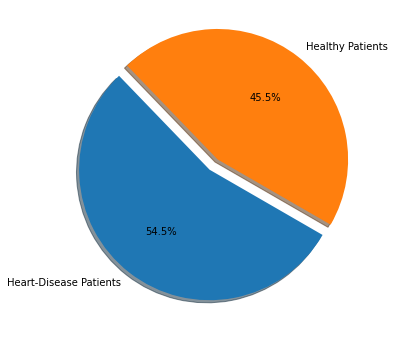

In [7]:
#Let us first analyze the distribution of the target variable

MAP={}
for e, i in enumerate(sorted(df[target].unique())):
    MAP[i]=labels[e]
#MAP={0:'Not-Survived',1:'Survived'}
df1 = df.copy()
df1[target]=df1[target].map(MAP)
explode=np.zeros(len(labels))
explode[-1]=0.1
print('\033[1mTarget Variable Distribution'.center(55))
plt.pie(df1[target].value_counts(), labels=df1[target].value_counts().index, counterclock=False, shadow=True, 
        explode=explode, autopct='%1.1f%%', radius=1, startangle=-30)
plt.show()

**Inference:** The Target Variable seems to be slightly imbalanced! Hence we shall try to perform data augmentation.

                               Visualising Categorical Features:                                


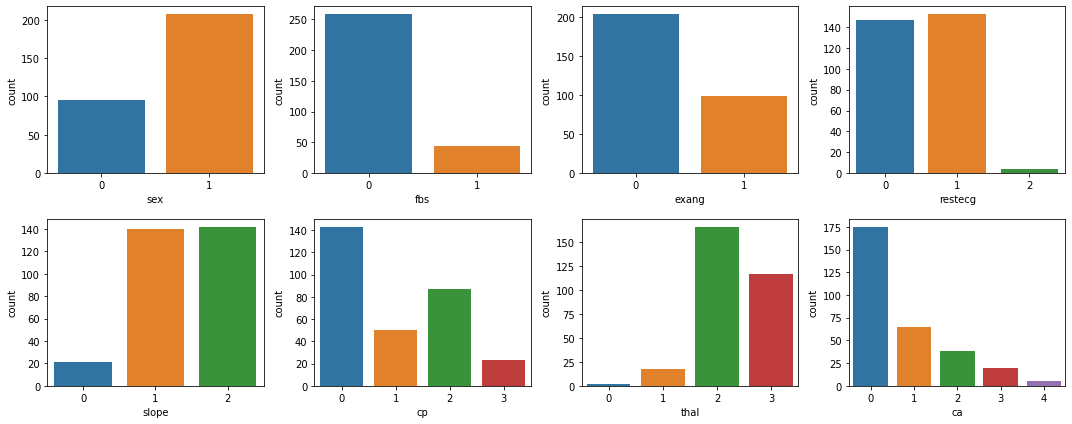

In [8]:
#Visualising the categorical features 

print('\033[1mVisualising Categorical Features:'.center(100))

n=4
plt.figure(figsize=[15,3*math.ceil(len(cf)/n)])

for i in range(len(cf)):
    if df[cf[i]].nunique()<=6:
        plt.subplot(math.ceil(len(cf)/n),n,i+1)
        sns.countplot(df[cf[i]])
    else:
        plt.subplot(3,1,i-1)
        sns.countplot(df[cf[i]])
plt.tight_layout()
plt.show()

**Inference:** Visualizing the categorical features reveal lot of information about the dataset.

                                     Features Distribution                                      


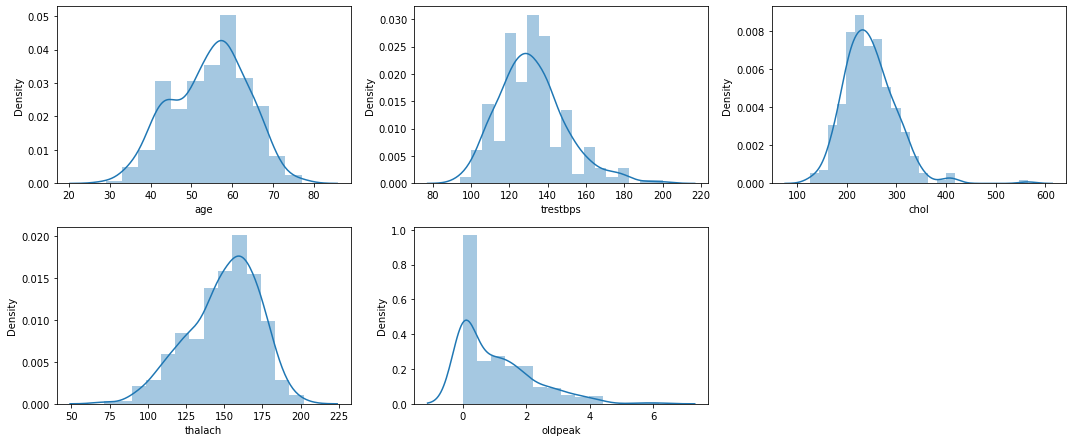

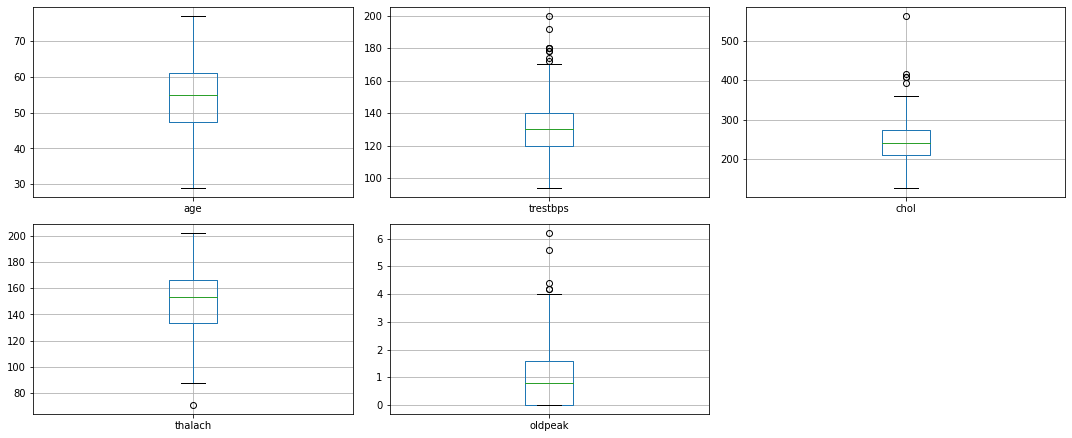

In [9]:
#Understanding the feature set

print('\033[1mFeatures Distribution'.center(100))

n=3
nf = [i for i in features if i not in cf]

plt.figure(figsize=[15,3*math.ceil(len(features)/3)])
for c in range(len(nf)):
    plt.subplot(math.ceil(len(features)/3),n,c+1)
    sns.distplot(df[nf[c]])
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,3*math.ceil(len(features)/3)])
for c in range(len(nf)):
    plt.subplot(math.ceil(len(features)/3),n,c+1)
    df.boxplot(nf[c])
plt.tight_layout()
plt.show()

**Inference:** The data is somewhat normally distributed. And there are many outliers present in the dataset. We shall fix these outliers..

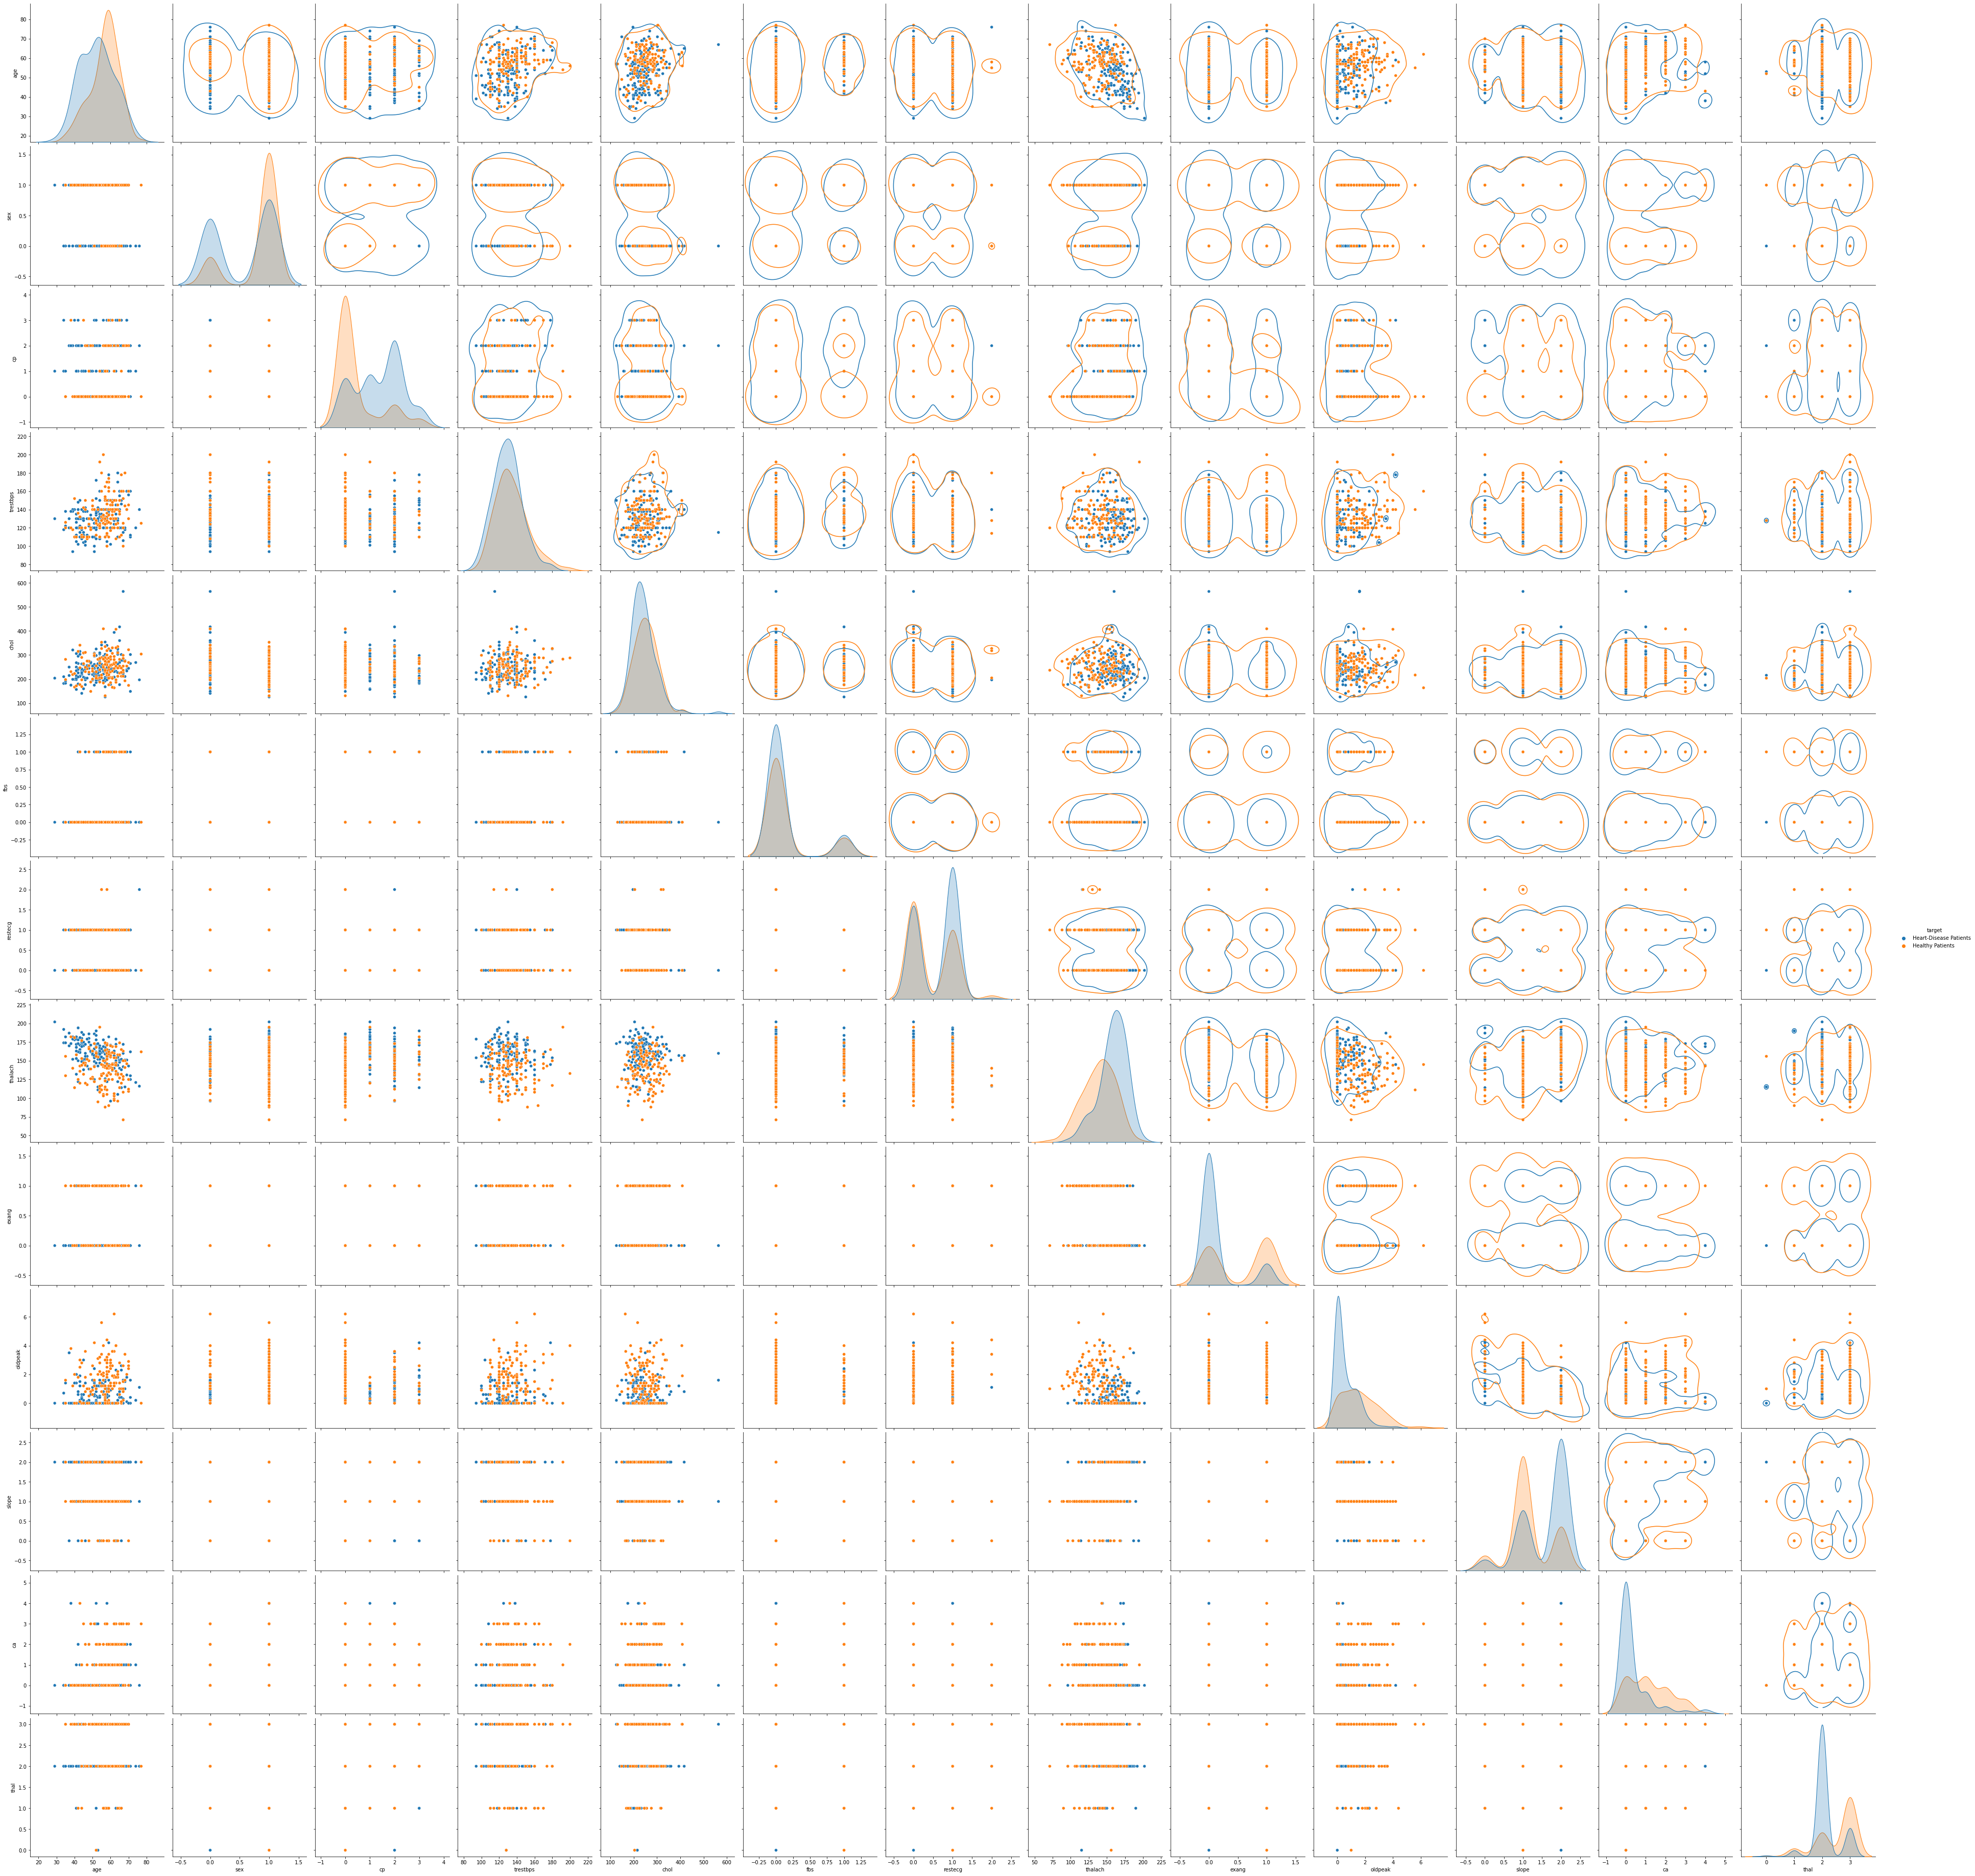

In [10]:
#Understanding the relationship between all the features

g=sns.pairplot(df1, hue=target, size=4)
g.map_upper(sns.kdeplot, levels=1, color=".2")
plt.show()

**Inference:** The data samples of most of the features do show some patterns. Also they seem
to have lot of overlap for the outcome classes, making it difficult to be distingusihable. 
Let is proceed to perform cleanup on the data to remove the irregularities...

---

# <center> 3. Data Preprocessing

In [11]:
#Removal of any Duplicate rows (if any)

counter = 0
r,c = original_df.shape

df1 = df.copy()
df1.drop_duplicates(inplace=True)
df1.reset_index(drop=True,inplace=True)

if df1.shape==(r,c):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped ---> {r-df1.shape[0]}')


Inference: Number of duplicates dropped ---> 1


In [12]:
#Check for empty elements

nvc = pd.DataFrame(df1.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df1.shape[0],3)*100
print(nvc)

          Total Null Values  Percentage
age                       0         0.0
sex                       0         0.0
cp                        0         0.0
trestbps                  0         0.0
chol                      0         0.0
fbs                       0         0.0
restecg                   0         0.0
thalach                   0         0.0
exang                     0         0.0
oldpeak                   0         0.0
slope                     0         0.0
ca                        0         0.0
thal                      0         0.0
target                    0         0.0


**Inference:** There are many outliers in the dataset. Let us try to impute the missing values

In [13]:
#Converting categorical Columns to Numeric

#df1 = df.copy()
ecc = nvc[nvc['Percentage']!=0].index.values
dcc = [i for i in df.columns if i not in ecc]

df3 = df1[dcc]
fcc = [i for i in cf if i not in ecc]

#One-Hot Binay Encoding
oh=True
dm=True
for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("\033[1m\nOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2 and df3[i].nunique()<17):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)
        
df3.shape


One-Hot Encoding on features:
sex
fbs
exang

Dummy Encoding on features:
restecg
slope
cp
thal
ca


(302, 23)

In [14]:
#Removal of outlier:

df4 = df3.copy()

for i in [i for i in df4.columns]:
    if df4[i].nunique()>=12:
        Q1 = df4[i].quantile(0.25)
        Q3 = df4[i].quantile(0.75)
        IQR = Q3 - Q1
        df4 = df4[df4[i] <= (Q3+(1.5*IQR))]
        df4 = df4[df4[i] >= (Q1-(1.5*IQR))]
df4 = df4.reset_index(drop=True)
display(df4.head())
print('\n\033[1mInference:\033[0m Before removal of outliers, The dataset had {} samples.'.format(df1.shape[0]))
print('\033[1mInference:\033[0m After removal of outliers, The dataset now has {} samples.'.format(df4.shape[0]))

age  sex  trestbps  chol  fbs  thalach  exang  oldpeak  target  restecg_1  \
0   63    1       145   233    1      150      0      2.3       1          0   
1   37    1       130   250    0      187      0      3.5       1          1   
2   41    0       130   204    0      172      0      1.4       1          0   
3   56    1       120   236    0      178      0      0.8       1          1   
4   57    0       120   354    0      163      1      0.6       1          1   

   restecg_2  slope_1  slope_2  cp_1  cp_2  cp_3  thal_1  thal_2  thal_3  \
0          0        0        0     0     0     1       1       0       0   
1          0        0        0     0     1     0       0       1       0   
2          0        0        1     1     0     0       0       1       0   
3          0        0        1     1     0     0       0       1       0   
4          0        0        1     0     0     0       0       1       0   

   ca_1  ca_2  ca_3  ca_4  
0     0     0     0     0  
1     0     0     0     0  
2     0     0     0     0  
3     0     0     0     0  
4     0     0     0     0


Inference: Before removal of outliers, The dataset had 302 samples.
Inference: After removal of outliers, The dataset now has 283 samples.


In [15]:
#Fixing the imbalance using SMOTE Technique

df5 = df4.copy()

print('Original class distribution:')
print(df5[target].value_counts())

xf = df5.columns
X = df5.drop([target],axis=1)
Y = df5[target]

smote = SMOTE()
X, Y = smote.fit_resample(X, Y)

df5 = pd.DataFrame(X, columns=xf)
df5[target] = Y

print('\nClass distribution after applying SMOTE Technique:',)
print(Y.value_counts())

Original class distribution:
1    158
0    125
Name: target, dtype: int64

Class distribution after applying SMOTE Technique:
1    158
0    158
Name: target, dtype: int64


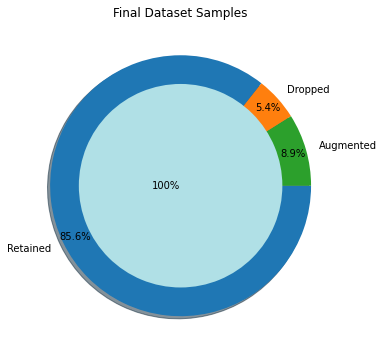


Inference:The final dataset after cleanup has 316 samples & 23 columns.


In [16]:
#Final Dataset size after performing Preprocessing

df = df5.copy()
plt.title('Final Dataset Samples')
plt.pie([df.shape[0], original_df.shape[0]-df4.shape[0], df5.shape[0]-df4.shape[0]], radius = 1, shadow=True,
        labels=['Retained','Dropped','Augmented'], counterclock=False, autopct='%1.1f%%', pctdistance=0.9, explode=[0,0,0])
plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78, shadow=True, colors=['powderblue'])
plt.show()

print('\n\033[1mInference:\033[0mThe final dataset after cleanup has {} samples & {} columns.'.format(df.shape[0], df.shape[1]))

---

# <center> 4. Data Manipulation

In [17]:
#Splitting the data intro training & testing sets

df = df5.copy()

X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=0)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (316, 22) (316,) 
Training set  --->  (252, 22) (252,) 
Testing set   --->  (64, 22)  (64,)


In [18]:
#Feature Scaling (Standardization)

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(100))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(100))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                               Standardardization on Training set                               


age           sex      trestbps          chol           fbs  \
count  2.520000e+02  2.520000e+02  2.520000e+02  2.520000e+02  2.520000e+02   
mean  -1.696174e-16  1.330505e-16 -3.216122e-16  1.013299e-17 -7.753939e-17   
std    1.001990e+00  1.001990e+00  1.001990e+00  1.001990e+00  1.001990e+00   
min   -2.834471e+00 -1.581139e+00 -2.459871e+00 -2.676787e+00 -3.813850e-01   
25%   -8.233400e-01 -1.581139e+00 -7.066811e-01 -7.506640e-01 -3.813850e-01   
50%    1.822255e-01  6.324555e-01 -3.237729e-02 -4.655281e-02 -3.813850e-01   
75%    6.291435e-01  6.324555e-01  6.419266e-01  6.575584e-01 -3.813850e-01   
max    2.528545e+00  6.324555e-01  2.664838e+00  2.769892e+00  2.622022e+00   

            thalach         exang       oldpeak     restecg_1     restecg_2  \
count  2.520000e+02  2.520000e+02  2.520000e+02  2.520000e+02  2.520000e+02   
mean  -5.286776e-16  1.762259e-17  7.753939e-17 -3.083953e-17 -2.203925e-16   
std    1.001990e+00  1.001990e+00  1.001990e+00  1.001990e+00  1.001990e+00   
min   -2.635305e+00 -6.819943e-01 -9.891246e-01 -9.309493e-01 -8.944272e-02   
25%   -7.050459e-01 -6.819943e-01 -9.891246e-01 -9.309493e-01 -8.944272e-02   
50%    1.284750e-01 -6.819943e-01 -2.316829e-01 -9.309493e-01 -8.944272e-02   
75%    6.549093e-01  1.466288e+00  7.151193e-01  1.074172e+00 -8.944272e-02   
max    2.365821e+00  1.466288e+00  2.798084e+00  1.074172e+00  1.118034e+01   

            slope_1       slope_2          cp_1          cp_2          cp_3  \
count  2.520000e+02  2.520000e+02  2.520000e+02  2.520000e+02  2.520000e+02   
mean   5.286776e-18  9.868649e-17 -6.300075e-17  1.682957e-16 -1.762259e-18   
std    1.001990e+00  1.001990e+00  1.001990e+00  1.001990e+00  1.001990e+00   
min   -9.016372e-01 -8.944272e-01 -4.279002e-01 -5.956834e-01 -2.515773e-01   
25%   -9.016372e-01 -8.944272e-01 -4.279002e-01 -5.956834e-01 -2.515773e-01   
50%   -9.016372e-01 -8.944272e-01 -4.279002e-01 -5.956834e-01 -2.515773e-01   
75%    1.109094e+00  1.118034e+00 -4.279002e-01  1.678744e+00 -2.515773e-01   
max    1.109094e+00  1.118034e+00  2.336993e+00  1.678744e+00  3.974921e+00   

             thal_1        thal_2        thal_3          ca_1          ca_2  \
count  2.520000e+02  2.520000e+02  2.520000e+02  2.520000e+02  2.520000e+02   
mean   1.409807e-17  1.233581e-17 -2.731501e-17  1.524354e-16  1.603655e-16   
std    1.001990e+00  1.001990e+00  1.001990e+00  1.001990e+00  1.001990e+00   
min   -2.515773e-01 -1.007968e+00 -7.647913e-01 -5.529010e-01 -3.606173e-01   
25%   -2.515773e-01 -1.007968e+00 -7.647913e-01 -5.529010e-01 -3.606173e-01   
50%   -2.515773e-01  9.920947e-01 -7.647913e-01 -5.529010e-01 -3.606173e-01   
75%   -2.515773e-01  9.920947e-01  1.307546e+00 -5.529010e-01 -3.606173e-01   
max    3.974921e+00  9.920947e-01  1.307546e+00  1.808642e+00  2.773023e+00   

               ca_3          ca_4  
count  2.520000e+02  2.520000e+02  
mean   9.053604e-17  1.561802e-16  
std    1.001990e+00  1.001990e+00  
min   -2.032789e-01 -1.097643e-01  
25%   -2.032789e-01 -1.097643e-01  
50%   -2.032789e-01 -1.097643e-01  
75%   -2.032789e-01 -1.097643e-01  
max    4.919350e+00  9.110434e+00


                                Standardardization on Testing set                                


age        sex   trestbps       chol        fbs    thalach  \
count  64.000000  64.000000  64.000000  64.000000  64.000000  64.000000   
mean   -0.009810  -0.059293  -0.081896  -0.082922  -0.005959   0.096944   
std     0.961436   1.034139   1.043884   1.180445   1.001136   0.977379   
min    -2.275823  -1.581139  -2.055289  -2.374193  -0.381385  -1.977262   
25%    -0.599881  -1.581139  -0.706681  -0.878684  -0.381385  -0.705046   
50%     0.014631   0.632456  -0.167238  -0.162935  -0.381385   0.325888   
75%     0.740873   0.632456   0.540781   0.634282  -0.381385   1.016833   
max     1.858168   0.632456   2.664838   2.606957   2.622022   1.839386   

           exang    oldpeak  restecg_1     restecg_2    slope_1    slope_2  \
count  64.000000  64.000000  64.000000  6.400000e+01  64.000000  64.000000   
mean   -0.044223  -0.032540   0.134272 -8.944272e-02   0.135146  -0.013975   
std     0.989268   0.895823   1.008511  1.258875e-16   1.012818   1.006231   
min    -0.681994  -0.989125  -0.930949 -8.944272e-02  -0.901637  -0.894427   
25%    -0.681994  -0.989125  -0.930949 -8.944272e-02  -0.901637  -0.894427   
50%    -0.681994  -0.087288   1.074172 -8.944272e-02   1.109094  -0.894427   
75%     1.466288   0.715119   1.074172 -8.944272e-02   1.109094   1.118034   
max     1.466288   2.419363   1.074172 -8.944272e-02   1.109094   1.118034   

            cp_1       cp_2       cp_3     thal_1     thal_2     thal_3  \
count  64.000000  64.000000  64.000000  64.000000  64.000000  64.000000   
mean    0.004114   0.008461   0.210696  -0.119499   0.054565   0.077096   
std     1.011847   1.012477   1.329557   0.741193   1.005966   1.025838   
min    -0.427900  -0.595683  -0.251577  -0.251577  -1.007968  -0.764791   
25%    -0.427900  -0.595683  -0.251577  -0.251577  -1.007968  -0.764791   
50%    -0.427900  -0.595683  -0.251577  -0.251577   0.992095  -0.764791   
75%    -0.427900   1.678744  -0.251577  -0.251577   0.992095   1.307546   
max     2.336993   1.678744   3.974921   3.974921   0.992095   1.307546   

            ca_1       ca_2       ca_3       ca_4  
count  64.000000  64.000000  64.000000  64.000000  
mean   -0.147011  -0.017875   0.276968   0.034301  
std     0.897987   0.985769   1.504951   1.152525  
min    -0.552901  -0.360617  -0.203279  -0.109764  
25%    -0.552901  -0.360617  -0.203279  -0.109764  
50%    -0.552901  -0.360617  -0.203279  -0.109764  
75%    -0.552901  -0.360617  -0.203279  -0.109764  
max     1.808642   2.773023   4.919350   9.110434

---

# <center> 5. Feature Selection/Extraction

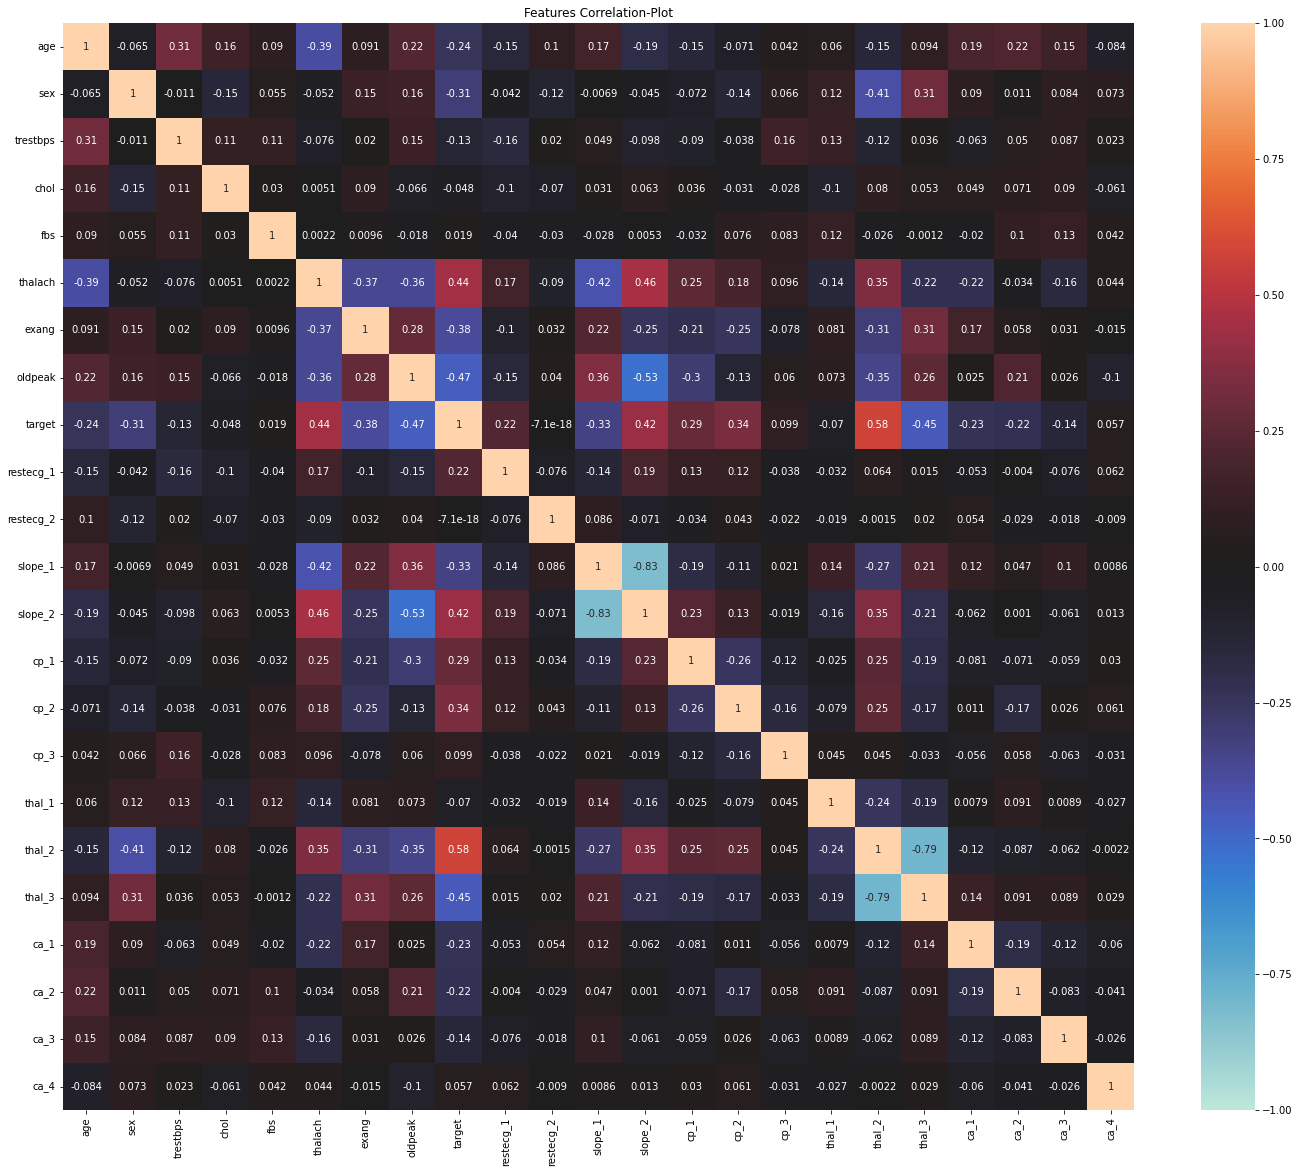

In [19]:
#Checking the correlation

features = df.columns
plt.figure(figsize=[24,20])
plt.title('Features Correlation-Plot')
sns.heatmap(df[features].corr(), vmin=-1, vmax=1, center=0, annot=True) #, 
plt.show()

**Inference:** \
Correlation plt between the variables convey lot of information about the realationship betweem them. There seems to be strong multicollinearity in the dataset.

Let us check with different techniques if we can improve the model's performance by performing Feature Selection/Extraction steps to take care of these multi-collinearity...

**Strategy:** \
We can fix these multicollinearity with two techniques:
1. Manual Method - Variance Inflation Factor (VIF)
2. Automatic Method - Recursive Feature Elimination (RFE)
3. Decomposition Method - Principle Component Analysis (PCA)

## 5a. Manual Method - VIF

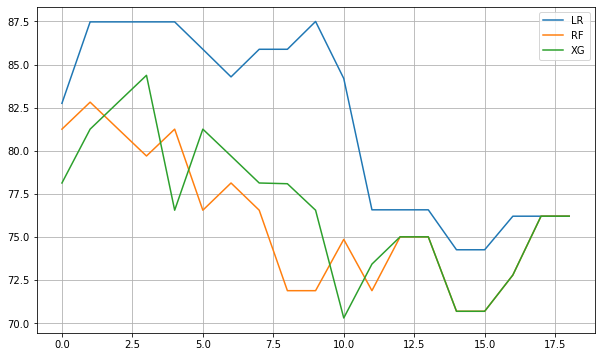

In [20]:
# Calculate the VIFs to remove multicollinearity

DROP=[]; scores1=[]; scores2=[]; scores3=[]
scores1.append(f1_score(Test_Y,LogisticRegression().fit(Train_X_std.drop(DROP,axis=1), Train_Y).predict(Test_X_std.drop(DROP,axis=1)),average='weighted')*100)
scores2.append(f1_score(Test_Y,RandomForestClassifier().fit(Train_X_std.drop(DROP,axis=1), Train_Y).predict(Test_X_std.drop(DROP,axis=1)),average='weighted')*100)
scores3.append(f1_score(Test_Y,XGBClassifier().fit(Train_X_std.drop(DROP,axis=1), Train_Y, eval_metric='logloss').predict(Test_X_std.drop(DROP,axis=1)),average='weighted')*100)
        
for i in range(len(X.columns.values)-1):
    vif = pd.DataFrame()
    Xs = X.drop(DROP,axis=1)
    #print(DROP)
    vif['Features'] = Xs.columns
    vif['VIF'] = [variance_inflation_factor(Xs.values, i) for i in range(Xs.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    vif.reset_index(drop=True, inplace=True)
    DROP.append(vif.Features[0])
    if vif.VIF[0]>1:
        scores1.append(f1_score(Test_Y,LogisticRegression().fit(Train_X_std.drop(DROP,axis=1), Train_Y).predict(Test_X_std.drop(DROP,axis=1)),average='weighted')*100)
        scores2.append(f1_score(Test_Y,RandomForestClassifier().fit(Train_X_std.drop(DROP,axis=1), Train_Y).predict(Test_X_std.drop(DROP,axis=1)),average='weighted')*100)
        scores3.append(f1_score(Test_Y,XGBClassifier().fit(Train_X_std.drop(DROP,axis=1), Train_Y, eval_metric='logloss').predict(Test_X_std.drop(DROP,axis=1)),average='weighted')*100)
    #print(scores)
    
plt.plot(scores1, label='LR')
plt.plot(scores2, label='RF')
plt.plot(scores3, label='XG')
#plt.ylim([0.7,0.85])
plt.legend()
plt.grid()
plt.show()

## 5b. Automatic Method - RFE

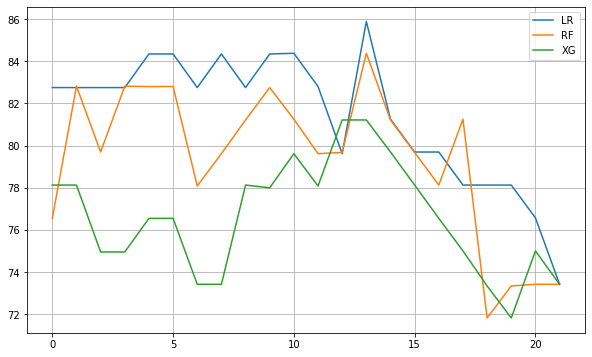

In [21]:
# Applying Recurrsive Feature Elimination

# Running RFE with the output number of the variable equal to 10
LR = LogisticRegression()
scores1=[]; scores2=[]; scores3=[]

for i in range(len(X.columns.values)):
    rfe = RFE(LR,n_features_to_select=len(Train_X_std.columns)-i)   
    rfe = rfe.fit(Train_X_std, Train_Y)
    scores1.append(f1_score(Test_Y,LogisticRegression().fit(Train_X_std[Train_X_std.columns[rfe.support_]], Train_Y).predict(Test_X_std[Train_X_std.columns[rfe.support_]]),average='weighted')*100)
    scores2.append(f1_score(Test_Y,RandomForestClassifier().fit(Train_X_std[Train_X_std.columns[rfe.support_]], Train_Y).predict(Test_X_std[Train_X_std.columns[rfe.support_]]),average='weighted')*100)
    scores3.append(f1_score(Test_Y,XGBClassifier().fit(Train_X_std[Train_X_std.columns[rfe.support_]], Train_Y, eval_metric='logloss').predict(Test_X_std[Train_X_std.columns[rfe.support_]]),average='weighted')*100)
    
plt.plot(scores1, label='LR')
plt.plot(scores2, label='RF')
plt.plot(scores3, label='XG')
plt.legend()
plt.grid()
plt.show()

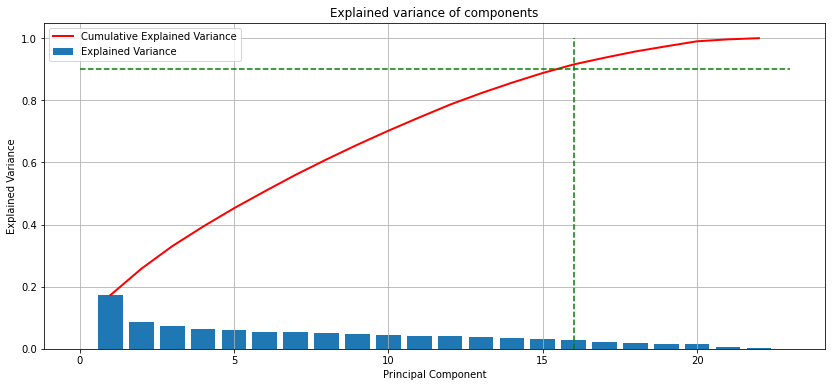

In [22]:
from sklearn.decomposition import PCA

pca = PCA().fit(Train_X_std)

fig, ax = plt.subplots(figsize=(14,6))
x_values = range(1, pca.n_components_+1)
ax.bar(x_values, pca.explained_variance_ratio_, lw=2, label='Explained Variance')
ax.plot(x_values, np.cumsum(pca.explained_variance_ratio_), lw=2, label='Cumulative Explained Variance', color='red')
plt.plot([0,pca.n_components_+1],[0.90,0.90],'g--')
plt.plot([16,16],[0,1], 'g--')
ax.set_title('Explained variance of components')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
plt.grid()
plt.legend()
plt.show()

**Inference:** We shall avoid performing dimensionality reduction for the current problem.

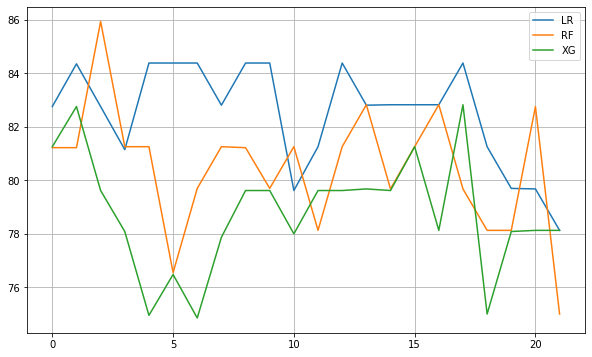

In [23]:
#Applying PCA Transformations

scores1=[]; scores2=[]; scores3=[]
for i in range(len(X.columns.values)):
    pca = PCA(n_components=Train_X_std.shape[1]-i)
    Train_X_std_pca = pca.fit_transform(Train_X_std)
    Train_X_std_pca = pd.DataFrame(Train_X_std_pca)

    Test_X_std_pca = pca.transform(Test_X_std)
    Test_X_std_pca = pd.DataFrame(Test_X_std_pca)
    
    scores1.append(f1_score(Test_Y,LogisticRegression().fit(Train_X_std_pca, Train_Y).predict(Test_X_std_pca),average='weighted')*100)
    scores2.append(f1_score(Test_Y,RandomForestClassifier().fit(Train_X_std_pca, Train_Y).predict(Test_X_std_pca),average='weighted')*100)
    scores3.append(f1_score(Test_Y,XGBClassifier().fit(Train_X_std_pca, Train_Y, eval_metric='logloss').predict(Test_X_std_pca),average='weighted')*100)

    
plt.plot(scores1, label='LR')
plt.plot(scores2, label='RF')
plt.plot(scores3, label='XG')
plt.legend()
plt.grid()
plt.show()

**Inference:** In VIF, RFE & PCA Techniques, we did notice any better scores upon dropping some multicollinear features. But in order to avoid the curse of dimensionality, we can capture top 90% of the data Variance explained by top n PCA components.

---

# <center> 6. Predictive Modeling

In [25]:
#Let us create first create a table to store the results of various models 

Evaluation_Results = pd.DataFrame(np.zeros((8,5)), columns=['Accuracy', 'Precision','Recall','F1-score','AUC-ROC score'])
Evaluation_Results.index=['Logistic Regression (LR)','Decision Tree Classifier (DT)','Random Forest Classifier (RF)','Naïve Bayes Classifier (NB)',
                         'Support Vector Machine (SVM)','K Nearest Neighbours (KNN)', 'Gradient Boosting (GB)','Extreme Gradient Boosting (XGB)']
Evaluation_Results

Accuracy  Precision  Recall  F1-score  \
Logistic Regression (LR)              0.0        0.0     0.0       0.0   
Decision Tree Classifier (DT)         0.0        0.0     0.0       0.0   
Random Forest Classifier (RF)         0.0        0.0     0.0       0.0   
Naïve Bayes Classifier (NB)           0.0        0.0     0.0       0.0   
Support Vector Machine (SVM)          0.0        0.0     0.0       0.0   
K Nearest Neighbours (KNN)            0.0        0.0     0.0       0.0   
Gradient Boosting (GB)                0.0        0.0     0.0       0.0   
Extreme Gradient Boosting (XGB)       0.0        0.0     0.0       0.0   

                                 AUC-ROC score  
Logistic Regression (LR)                   0.0  
Decision Tree Classifier (DT)              0.0  
Random Forest Classifier (RF)              0.0  
Naïve Bayes Classifier (NB)                0.0  
Support Vector Machine (SVM)               0.0  
K Nearest Neighbours (KNN)                 0.0  
Gradient Boosting (GB)                     0.0  
Extreme Gradient Boosting (XGB)            0.0

In [26]:
#Let us define functions to summarise the Prediction's scores .

#Classification Summary Function
def Classification_Summary(pred,pred_prob,i):
    Evaluation_Results.iloc[i]['Accuracy']=round(accuracy_score(Test_Y, pred),3)*100   
    Evaluation_Results.iloc[i]['Precision']=round(precision_score(Test_Y, pred, average='weighted'),3)*100 #
    Evaluation_Results.iloc[i]['Recall']=round(recall_score(Test_Y, pred, average='weighted'),3)*100 #
    Evaluation_Results.iloc[i]['F1-score']=round(f1_score(Test_Y, pred, average='weighted'),3)*100 #
    Evaluation_Results.iloc[i]['AUC-ROC score']=round(roc_auc_score(Test_Y, pred_prob[:,1], multi_class='ovr'),3)*100 #[:, 1]
    print('{}{}\033[1m Evaluating {} \033[0m{}{}\n'.format('<'*3,'-'*35,Evaluation_Results.index[i], '-'*35,'>'*3))
    print('Accuracy = {}%'.format(round(accuracy_score(Test_Y, pred),3)*100))
    print('F1 Score = {}%'.format(round(f1_score(Test_Y, pred, average='weighted'),3)*100)) #
    print('\n \033[1mConfusiton Matrix:\033[0m\n',confusion_matrix(Test_Y, pred))
    print('\n\033[1mClassification Report:\033[0m\n',classification_report(Test_Y, pred))
    
    auc_roc(Test_Y, pred_prob, curves=['each_class'])
    plt.show()

#Visualising Function
def AUC_ROC_plot(Test_Y, pred):    
    ref = [0 for _ in range(len(Test_Y))]
    ref_auc = roc_auc_score(Test_Y, ref)
    lr_auc = roc_auc_score(Test_Y, pred)

    ns_fpr, ns_tpr, _ = roc_curve(Test_Y, ref)
    lr_fpr, lr_tpr, _ = roc_curve(Test_Y, pred)

    plt.plot(ns_fpr, ns_tpr, linestyle='--')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='AUC = {}'.format(round(roc_auc_score(Test_Y, pred)*100,2))) 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

---

## 1. Logistic Regression:

<<<----------------------------------- Evaluating Logistic Regression (LR) ----------------------------------->>>

Accuracy = 84.39999999999999%
F1 Score = 84.3%

 Confusiton Matrix:
 [[26  7]
 [ 3 28]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.79      0.84        33
           1       0.80      0.90      0.85        31

    accuracy                           0.84        64
   macro avg       0.85      0.85      0.84        64
weighted avg       0.85      0.84      0.84        64



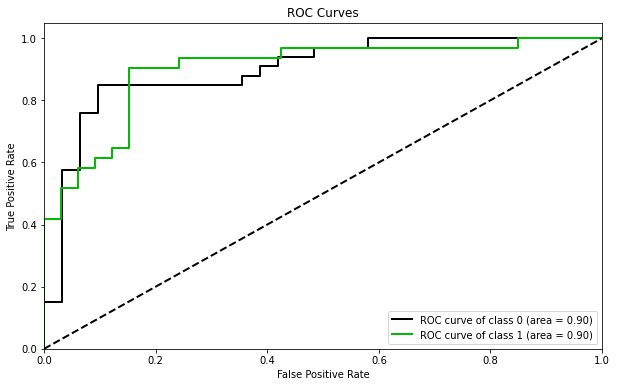


Interpreting the Output of Logistic Regression:

intercept  6.908678584413832e-05
classes [0 1]


coeff
age        0.003553
sex       -0.497489
trestbps  -0.326922
chol      -0.235915
fbs        0.119095
thalach    0.242368
exang     -0.180921
oldpeak   -0.508921
restecg_1  0.321286
restecg_2  0.037382
slope_1   -0.060013
slope_2    0.428270
cp_1       0.337485
cp_2       0.766047
cp_3       0.376313
thal_1     0.243987
thal_2     0.680233
thal_3    -0.197945
ca_1      -0.611671
ca_2      -0.380955
ca_3      -0.132203
ca_4       0.093425

In [27]:
# Building Logistic Regression Classifier

LR_model = LogisticRegression()

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l2'] #'none', 'l1', 'l2', 'elasticnet'
space['C'] = loguniform(1e-5, 100)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(LR_model, space, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

LR = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = LR.predict(Test_X_std)
pred_prob = LR.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,0)

print('\n\033[1mInterpreting the Output of Logistic Regression:\n\033[0m')

print('intercept ', LR.intercept_[0])
print('classes', LR.classes_)
display(pd.DataFrame({'coeff': LR.coef_[0]}, index=Train_X_std.columns))

---

## 2. Decisoin Tree Classfier:

<<<----------------------------------- Evaluating Decision Tree Classifier (DT) ----------------------------------->>>

Accuracy = 70.3%
F1 Score = 70.3%

 Confusiton Matrix:
 [[23 10]
 [ 9 22]]

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.70      0.71        33
           1       0.69      0.71      0.70        31

    accuracy                           0.70        64
   macro avg       0.70      0.70      0.70        64
weighted avg       0.70      0.70      0.70        64



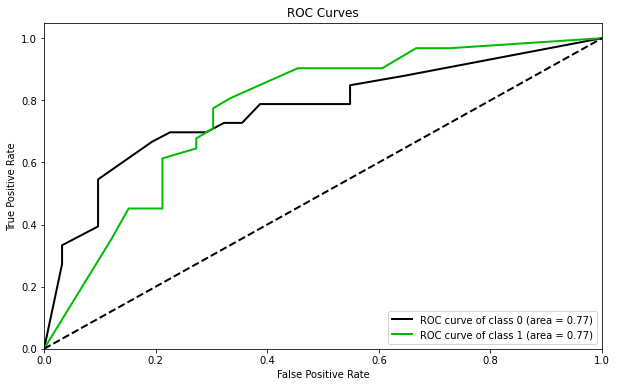


Interpreting the output of Decision Tree:



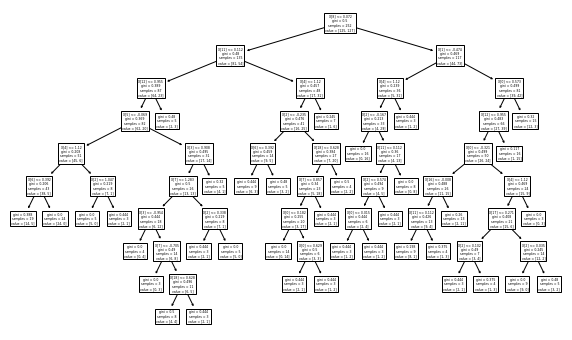

In [28]:
#Building Decision Tree Classifier

DT_model = DecisionTreeClassifier()

param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(DT_model, param_dist, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

DT = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = DT.predict(Test_X_std)
pred_prob = DT.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,1)

print('\n\033[1mInterpreting the output of Decision Tree:\n\033[0m')
tree.plot_tree(DT)
plt.show()

---

## 3. Random Forest Classfier:

<<<----------------------------------- Evaluating Random Forest Classifier (RF) ----------------------------------->>>

Accuracy = 79.7%
F1 Score = 79.7%

 Confusiton Matrix:
 [[26  7]
 [ 6 25]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.79      0.80        33
           1       0.78      0.81      0.79        31

    accuracy                           0.80        64
   macro avg       0.80      0.80      0.80        64
weighted avg       0.80      0.80      0.80        64



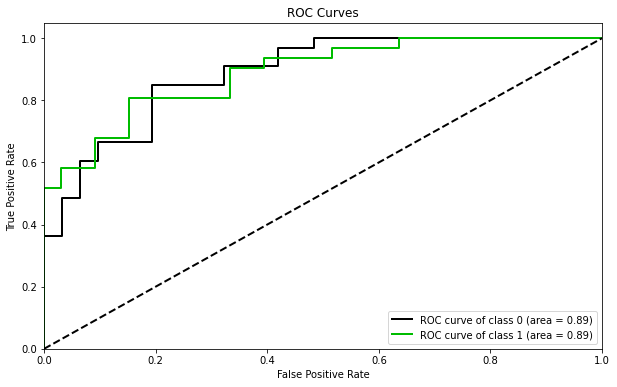


Interpreting the output of Random Forest:



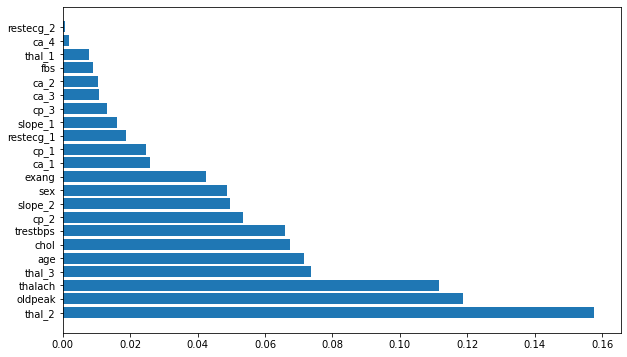

In [29]:
# Building Random-Forest Classifier

RF_model = RandomForestClassifier()

param_dist={'bootstrap': [True, False],
            'max_depth': [10, 20, 50, 100, None],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [50, 100]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(RF_model, param_dist, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

RF = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = RF.predict(Test_X_std)
pred_prob = RF.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,2)

print('\n\033[1mInterpreting the output of Random Forest:\n\033[0m')
rfi=pd.Series(RF.feature_importances_, index=Train_X_std.columns).sort_values(ascending=False)
plt.barh(rfi.index,rfi.values)
plt.show()

---

## 4. Naive Bayes Classfier:

<<<----------------------------------- Evaluating Naïve Bayes Classifier (NB) ----------------------------------->>>

Accuracy = 79.7%
F1 Score = 79.7%

 Confusiton Matrix:
 [[27  6]
 [ 7 24]]

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.82      0.81        33
           1       0.80      0.77      0.79        31

    accuracy                           0.80        64
   macro avg       0.80      0.80      0.80        64
weighted avg       0.80      0.80      0.80        64



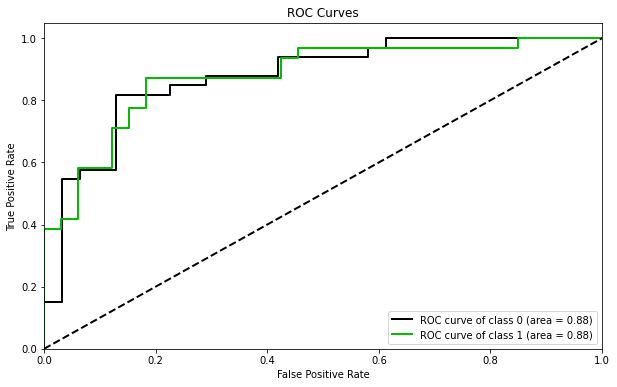

In [30]:
# Building Naive Bayes Classifier

NB_model = BernoulliNB()

params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(NB_model, params, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

NB = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = NB.predict(Test_X_std)
pred_prob = NB.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,3)

---

## 5. Support Vector Machine Classfier:

<<<----------------------------------- Evaluating Support Vector Machine (SVM) ----------------------------------->>>

Accuracy = 82.8%
F1 Score = 82.69999999999999%

 Confusiton Matrix:
 [[25  8]
 [ 3 28]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.76      0.82        33
           1       0.78      0.90      0.84        31

    accuracy                           0.83        64
   macro avg       0.84      0.83      0.83        64
weighted avg       0.84      0.83      0.83        64



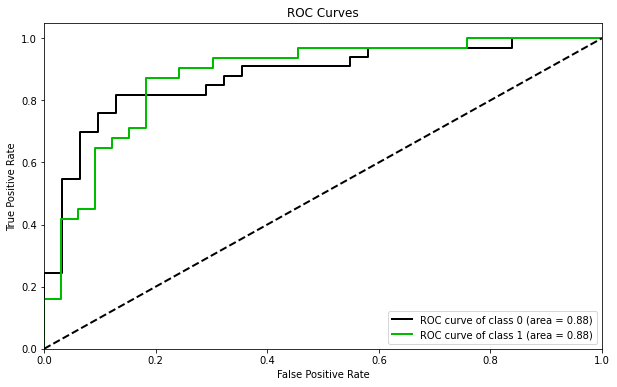

In [31]:
# Building Support Vector Machine Classifier

SVM_model = SVC(probability=True).fit(Train_X_std, Train_Y)

svm_param = {"C": [.01, .1, 1, 5, 10, 100],             
             "gamma": [.01, .1, 1, 5, 10, 100],
             "kernel": ["rbf"],
             "random_state": [1]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(SVM_model, svm_param, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

SVM = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = SVM.predict(Test_X_std)
pred_prob = SVM.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,4)

---

## 6. K-Nearest Neighbours Classfier:

<<<----------------------------------- Evaluating K Nearest Neighbours (KNN) ----------------------------------->>>

Accuracy = 81.2%
F1 Score = 81.2%

 Confusiton Matrix:
 [[26  7]
 [ 5 26]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.79      0.81        33
           1       0.79      0.84      0.81        31

    accuracy                           0.81        64
   macro avg       0.81      0.81      0.81        64
weighted avg       0.81      0.81      0.81        64



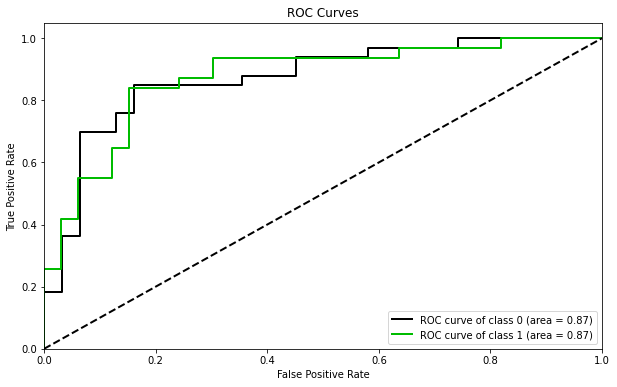

In [32]:
# Building K-Neareset Neighbours Classifier

KNN_model = KNeighborsClassifier()

knn_param = {"n_neighbors": [i for i in range(1,30,5)],
             "weights": ["uniform", "distance"],
             "algorithm": ["ball_tree", "kd_tree", "brute"],
             "leaf_size": [1, 10, 30],
             "p": [1,2]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(KNN_model, knn_param, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

KNN = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = KNN.predict(Test_X_std)
pred_prob = KNN.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,5)

---

## 7. Gradient Boosting Classfier:

<<<----------------------------------- Evaluating Gradient Boosting (GB) ----------------------------------->>>

Accuracy = 79.7%
F1 Score = 79.7%

 Confusiton Matrix:
 [[25  8]
 [ 5 26]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.76      0.79        33
           1       0.76      0.84      0.80        31

    accuracy                           0.80        64
   macro avg       0.80      0.80      0.80        64
weighted avg       0.80      0.80      0.80        64



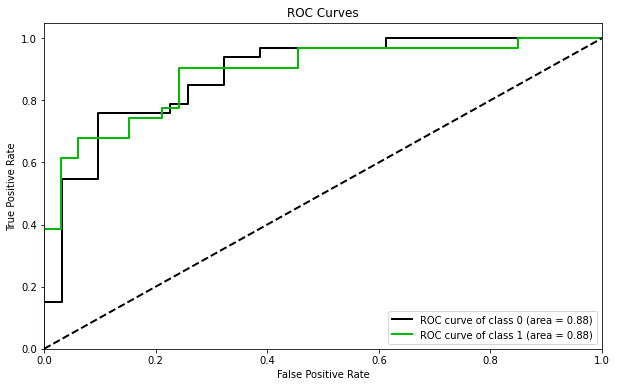

In [33]:
# Building Gradient Boosting Classifier

GB_model = GradientBoostingClassifier().fit(Train_X_std, Train_Y)
param_dist = {
    "n_estimators":[5,20,100,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(GB_model, param_dist, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

GB = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = GB.predict(Test_X_std)
pred_prob = GB.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,6)

---

## 8. Extreme Gradient Boosting Classfier:

<<<----------------------------------- Evaluating Extreme Gradient Boosting (XGB) ----------------------------------->>>

Accuracy = 78.10000000000001%
F1 Score = 78.10000000000001%

 Confusiton Matrix:
 [[25  8]
 [ 6 25]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.76      0.78        33
           1       0.76      0.81      0.78        31

    accuracy                           0.78        64
   macro avg       0.78      0.78      0.78        64
weighted avg       0.78      0.78      0.78        64



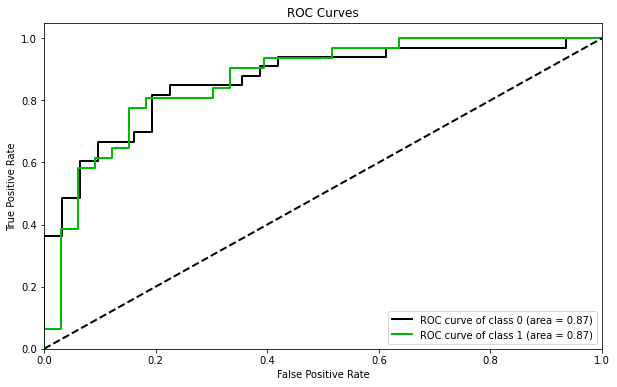

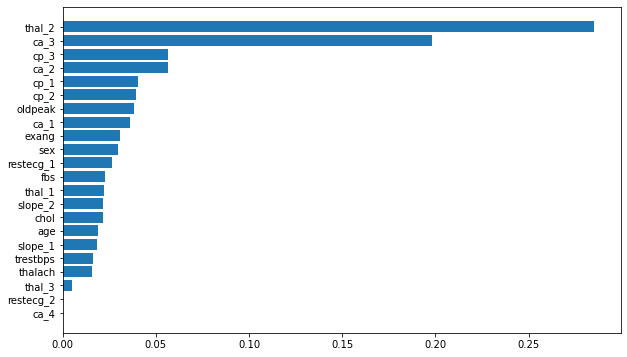

In [34]:
# Building Extreme Gradient Boosting Classifier

XGB_model = XGBClassifier()

param_dist = {
 "learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
 "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

XGB = XGB_model.fit(Train_X_std, Train_Y, eval_metric='logloss')
pred = XGB.predict(Test_X_std)
pred_prob = XGB.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,7)

xgbf=pd.DataFrame(XGB.feature_importances_, index=Train_X_std.columns).sort_values(by=0)
plt.barh(xgbf.index,xgbf.values[:,0])
plt.show()

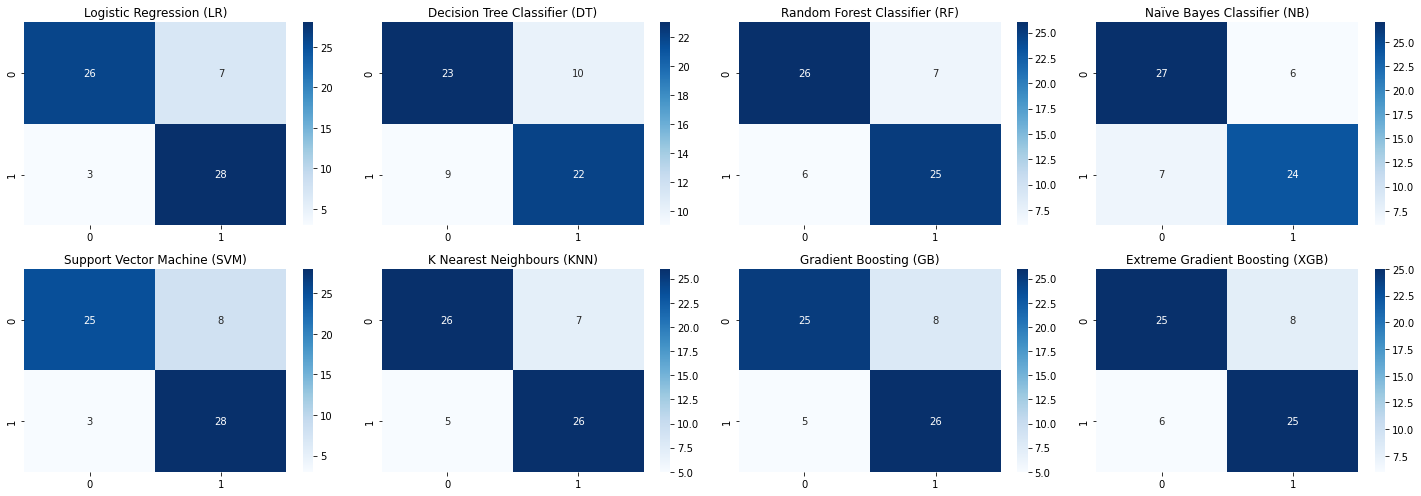

In [35]:
#Plotting Confusion-Matrix of all the predictive Models

def plot_cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.columns=labels
    cm.index=labels
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'

    sns.heatmap(cm, annot=annot, fmt='')# cmap= "GnBu"
    
def conf_mat_plot(all_models):
    plt.figure(figsize=[20,3.5*math.ceil(len(all_models)*len(labels)/14)])
    
    for i in range(len(all_models)):
        if len(labels)<=4:
            plt.subplot(2,4,i+1)
        else:
            plt.subplot(math.ceil(len(all_models)/3),3,i+1)
        pred = all_models[i].predict(Test_X_std)
        sns.heatmap(confusion_matrix(Test_Y, pred), annot=True, cmap='Blues', fmt='.0f') #vmin=0,vmax=5
        plt.title(Evaluation_Results.index[i])
    plt.tight_layout()
    plt.show()

conf_mat_plot([LR,DT,RF,NB,SVM,KNN,GB,XGB])

                                    ML Algorithms Comparison                                    


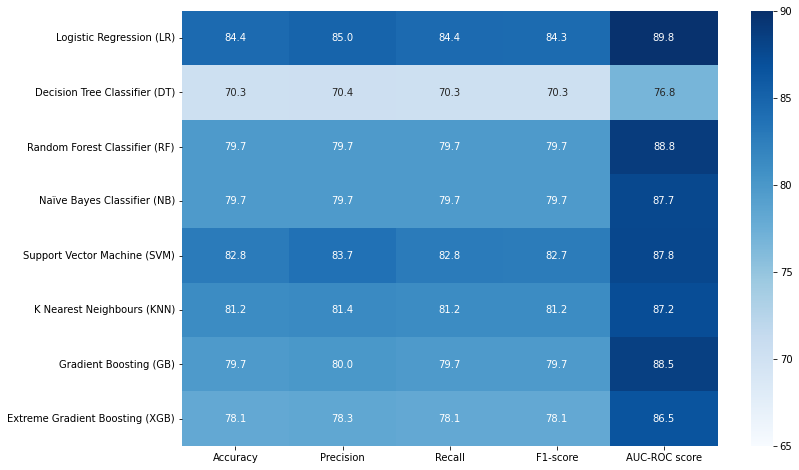

In [36]:
#Comparing all the models Scores

print('\033[1mML Algorithms Comparison'.center(100))
plt.figure(figsize=[12,8])
sns.heatmap(Evaluation_Results, annot=True, vmin=65, vmax=90, cmap='Blues', fmt='.1f')
plt.show()

**Insights:** For the current problem statement, it is more important to focus on the Recall score. We can note from the above heatmap that the SVM, Random Forest & Extreme Gradient Boosting Model Performed well on the current dataset...

---

# <center> 7. Project Outcomes & Conclusions

### Here are some of the key outcomes of the project:
- The Dataset was quiet small totalling around 303 samples & after preprocessing 5.4% of the datasamples were dropped. 
- The samples were slightly imbalanced after processing, hence SMOTE Technique was applied on the data to  balance the classes, adding 8.9% more samples to the dataset.
- Visualising the distribution of data & their relationships, helped us to get some insights on the relationship between the feature-set.
- Feature Selection/Eliminination was carried out and appropriate features were shortlisted.
- Testing multiple algorithms with fine-tuning hyperparamters gave us some understanding on the model performance for various algorithms on this specific dataset.
- Surprisingly the Logistic Regression & SVM Moelds outperformed most of the other models by a great Margin on the current dataset, considering Recall Score as the key-metric.
- Yet it wise to also consider simpler model like Logistic Regression as it is more generalisable & is computationally less expensive, but comes at the cost of slight misclassifications.

In [37]:
#<<<---------------------------------------------THE END----------------------------------------------------------------->>>